In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import seaborn as sns
import json
import matplotlib.pyplot as plt
from gensim import corpora, models

In [2]:
def load_json_to_df(datapass):
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

In [3]:
business = load_json_to_df("../../../dataset/business.json")

In [4]:
review = load_json_to_df("../../../dataset/review.json")

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0,VfBHSwC5Vz_pbFluy07i9Q,5,My girlfriend and I stayed here for 3 nights a...,0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0,3zRpneRKDsOPq92tq7ybAA,3,If you need an inexpensive place to stay for a...,0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0,ne5WhI1jUFOcRn-b-gAzHA,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,AXgRULmWcME7J6Ix3I--ww
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0,llmdwOgDReucVoWEry61Lw,4,Location is everything and this hotel has it! ...,0,oU2SSOmsp_A8JYI7Z2JJ5w
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0,DuffS87NaSMDmIfluvT83g,5,gute lage im stadtzentrum. shoppingmeile und s...,0,0xtbPEna2Kei11vsU-U2Mw
5,uYHaNptLzDLoV_JZ_MuzUA,0,2016-06-05,0,GvLmUkjUrOyFH8KFnmT1uw,5,Erstklassige Lage. Dazu ist alles geschrieben ...,0,rW8q706dz5-NnXDzMwVkiw
6,uYHaNptLzDLoV_JZ_MuzUA,0,2015-02-21,0,lGEl24NGj2HVBJrodeXcjg,4,"Beautiful space, great location, staff rock. T...",0,yx8vNXUL0D0HS8rUIC7AFA
7,uYHaNptLzDLoV_JZ_MuzUA,0,2013-07-07,0,cUgvEy5wj7zYE68v1BzzVg,4,This is a fairly new property I think. It is a...,0,zXnH6W74FAJQ7q7b-NuBsA
8,uYHaNptLzDLoV_JZ_MuzUA,2,2013-04-27,0,FSB_BnvysBgH3JYrbFNcgw,4,First time at this group of hotels. Pretty new...,2,c5yp5hxwC1N98MjbV2LyWQ
9,uYHaNptLzDLoV_JZ_MuzUA,0,2015-04-13,0,dhl3ZW9aAEX_T7_um5tfaQ,4,Location location location! \n\nMotel One is j...,2,xJisL5w4wOgiYLokGMT_IA


## Preprocessing:
Filter reviews of restaurants only and among those, select the reviews with 10 < "useful" < 500.
Use random samples from the clean dataset. Looking at the business with most reviews today for demo purpose.

In [9]:
is_rest = []
for i in business['categories']:
    
    if 'Restaurants' in i or 'Food' in i:
        is_rest.append(True)
    else:
        is_rest.append(False)
restaurants = business.loc[is_rest]
restaurants.shape

(65028, 15)

In [10]:
rest_id = restaurants['business_id']
rest_review = review.loc[review['business_id'].isin(rest_id)]
rest_review.shape

(3216548, 9)

In [36]:
#r = rest_review.sort_values('user_id'.count())
#r.head(10)

In [24]:
groupby_user = rest_review.groupby('user_id').size().reset_index(name='counts')

In [30]:
groupby_user.sort_values('counts',ascending=False)

,user_id,counts
186623,CxDOIDnH8gp9KXzpBHJYXw,2828
525915,bLbSNkLggFnqwNNzzq-Ijw,1473
191626,DK57YibC5ShBmqQl97CKog,1021
352049,PKEzKWv_FktMm2mGPjwd0Q,1001
555828,d_TBs6J3twMy9GChqUEXkg,991
539407,cMEtAiW60I5wE_vLfTxoJQ,934
205236,ELcQDlf69kb-ihJfxZyL0A,922
415516,U4INQZOPSUaj8hMjLlZ3KA,791
421891,UYcmGbelzRa0Q6JqzLoguw,790
365144,QJI9OSEn6ujRCtrX06vs1w,741


In [49]:
#preprocess
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.corpus import stopwords
en_stop = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

def preprocess(text):
    raw = text.lower()
    tokens = tokenizer.tokenize(raw)
    
    pospeech=[]
    tag = nltk.pos_tag(tokens)
    for j in tag:
        if j[1] == 'NN' or j[1] == 'JJ':
            pospeech.append(j[0])
    # remove stop words from tokens
    stopped_tokens = [i for i in pospeech if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    return stemmed_tokens



In [37]:
top1user = rest_review.loc[rest_review['user_id'] == 'CxDOIDnH8gp9KXzpBHJYXw']

In [50]:
texts = []
for t in top1user['text']:
    texts.append(preprocess(t))

In [51]:
from gensim import corpora, models

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
# generate LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)


In [52]:
print(ldamodel.print_topics(num_topics=5, num_words=10))

[(0, '0.015*"sweet" + 0.015*"good" + 0.014*"burger" + 0.013*"chicken" + 0.012*"chocol" + 0.011*"littl" + 0.009*"tast" + 0.008*"bakeri" + 0.007*"hot" + 0.007*"great"'), (1, '0.024*"food" + 0.017*"good" + 0.012*"restaur" + 0.012*"order" + 0.010*"menu" + 0.010*"littl" + 0.009*"time" + 0.007*"meat" + 0.007*"dinner" + 0.007*"fresh"'), (2, '0.026*"coffe" + 0.012*"area" + 0.012*"nice" + 0.012*"place" + 0.011*"bar" + 0.011*"beer" + 0.011*"great" + 0.010*"patio" + 0.010*"good" + 0.009*"littl"'), (3, '0.023*"lunch" + 0.021*"noodl" + 0.021*"soup" + 0.019*"good" + 0.016*"sushi" + 0.015*"rice" + 0.014*"spici" + 0.013*"restaur" + 0.012*"food" + 0.011*"beef"'), (4, '0.035*"tea" + 0.014*"ice" + 0.012*"good" + 0.011*"cream" + 0.011*"thai" + 0.009*"place" + 0.009*"littl" + 0.009*"free" + 0.008*"food" + 0.008*"sweet"')]


In [61]:
print (list(ldamodel.get_document_topics(corpus)))

[[(1, 0.98160475661044855)], [(0, 0.10351247914415389), (2, 0.39406203028790038), (3, 0.4853334948244446)], [(1, 0.86243603582336981), (3, 0.13233299126909179)], [(1, 0.61393731982076083), (4, 0.37072098748824345)], [(0, 0.96602692804771273)], [(1, 0.040552647813302103), (2, 0.94776755714374505)], [(0, 0.099527157129806212), (3, 0.63761176007205556), (4, 0.25983361228581969)], [(1, 0.47142654231967068), (2, 0.51288058757849331)], [(1, 0.41846648151218291), (2, 0.23154430419468139), (4, 0.34109641060796481)], [(1, 0.70303972025812134), (2, 0.28519274256579991)], [(2, 0.96750972984887351)], [(1, 0.68231245748988212), (3, 0.30998321868704426)], [(1, 0.84393624683144108), (3, 0.13426457301872669)], [(1, 0.89782239104488704), (3, 0.078630342108474388)], [(0, 0.096428241202251172), (1, 0.43174177029111654), (2, 0.42077424208689784), (4, 0.045084270130818137)], [(0, 0.015601348085133528), (1, 0.44144307229381596), (2, 0.278132883719311), (3, 0.015803655150525141), (4, 0.24901904075121445)], [

In [65]:
ldamodel.print_topics(12)

[(0,
  '0.015*"sweet" + 0.015*"good" + 0.014*"burger" + 0.013*"chicken" + 0.012*"chocol" + 0.011*"littl" + 0.009*"tast" + 0.008*"bakeri" + 0.007*"hot" + 0.007*"great"'),
 (1,
  '0.024*"food" + 0.017*"good" + 0.012*"restaur" + 0.012*"order" + 0.010*"menu" + 0.010*"littl" + 0.009*"time" + 0.007*"meat" + 0.007*"dinner" + 0.007*"fresh"'),
 (2,
  '0.026*"coffe" + 0.012*"area" + 0.012*"nice" + 0.012*"place" + 0.011*"bar" + 0.011*"beer" + 0.011*"great" + 0.010*"patio" + 0.010*"good" + 0.009*"littl"'),
 (3,
  '0.023*"lunch" + 0.021*"noodl" + 0.021*"soup" + 0.019*"good" + 0.016*"sushi" + 0.015*"rice" + 0.014*"spici" + 0.013*"restaur" + 0.012*"food" + 0.011*"beef"'),
 (4,
  '0.035*"tea" + 0.014*"ice" + 0.012*"good" + 0.011*"cream" + 0.011*"thai" + 0.009*"place" + 0.009*"littl" + 0.009*"free" + 0.008*"food" + 0.008*"sweet"')]

In [91]:
l = [0.0,0.0,0.0,0.0,0.0]
for i in ldamodel.get_document_topics(corpus):
    for topic in i:
        l[topic[0]] += topic[1]

In [94]:
topic_likelihood = []
for i in l:
    topic_likelihood.append(i/sum(l))
topic_likelihood

[0.1192815164564922,
 0.30378618797065166,
 0.18947133864515303,
 0.23097418844631903,
 0.15648676848138396]

In [97]:
print (ldamodel.log_perplexity(corpus))

-7.2268986254


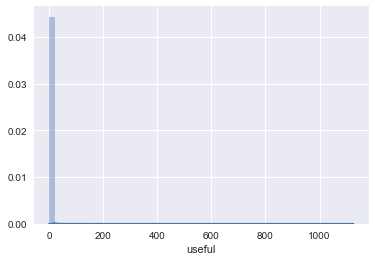

In [138]:
sns.distplot(rest_review['useful'])

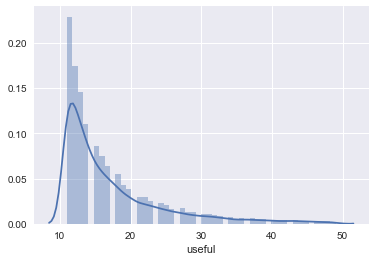

In [142]:
useful_reviews = rest_review.loc[rest_review['useful']>10]
useful_reviews = useful_reviews.loc[useful_reviews['useful']<50]
sns.distplot(useful_reviews['useful'])

In [144]:
result = restaurants.sort_values(by ='review_count', ascending=False)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
103325,3655 Las Vegas Blvd S,"{'Alcohol': 'full_bar', 'HasTV': False, 'Noise...",4JNXUYY8wbaaDmk3BPzlWw,"[French, Steakhouses, Breakfast & Brunch, Rest...",Las Vegas,"{'Monday': '7:00-23:00', 'Tuesday': '7:00-23:0...",1,36.112827,-115.172581,Mon Ami Gabi,The Strip,89109,6979,4.0,NV
125404,3570 S Las Vegas Blvd,"{'RestaurantsTableService': True, 'GoodForMeal...",RESDUcs7fIiihp38-d6_6g,"[Food, Restaurants, Buffets, Breakfast & Brunc...",Las Vegas,"{'Monday': '7:30-22:00', 'Tuesday': '7:30-22:0...",1,36.116113,-115.176222,Bacchanal Buffet,The Strip,89109,6417,4.0,NV
45588,3708 Las Vegas Blvd S,"{'RestaurantsTableService': True, 'GoodForMeal...",K7lWdNUhCbcnEvI0NhGewg,"[Buffets, Breakfast & Brunch, Restaurants]",Las Vegas,"{'Monday': '8:00-21:00', 'Tuesday': '8:00-21:0...",1,36.109447,-115.176271,Wicked Spoon,The Strip,89109,5632,3.5,NV
114018,3667 Las Vegas Blvd S,"{'RestaurantsTableService': True, 'GoodForMeal...",cYwJA2A6I12KNkm2rtXd5g,"[American (Traditional), Restaurants, Burgers]",Las Vegas,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",0,36.110724,-115.172169,Gordon Ramsay BurGR,The Strip,89109,5429,4.0,NV
100916,3667 Las Vegas Blvd S,"{'Alcohol': 'beer_and_wine', 'HasTV': True, 'N...",DkYS3arLOhA8si5uUEmHOw,"[Food Delivery Services, Restaurants, Caterers...",Las Vegas,"{'Monday': '0:00-0:00', 'Tuesday': '0:00-0:00'...",1,36.109362,-115.171874,Earl of Sandwich,The Strip,89109,4789,4.5,NV
104769,3535 Las Vegas Blvd,"{'RestaurantsTableService': True, 'GoodForMeal...",f4x1YBxkLrZg652xt2KR5g,"[American (New), Restaurants, Breakfast & Brunch]",Las Vegas,"{'Monday': '0:00-0:00', 'Tuesday': '0:00-0:00'...",1,36.118181,-115.171580,Hash House A Go Go,The Strip,89109,4371,4.0,NV
106981,"Caesars Palace Las Vegas Hotel And Casino, 357...","{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",eoHdUeQDNgQ6WYEnP2aiRw,"[Social Clubs, Restaurants, Desserts, Food, Am...",Las Vegas,"{'Monday': '9:00-22:00', 'Tuesday': '9:00-22:0...",0,36.115670,-115.173317,Serendipity 3,The Strip,89109,3913,3.0,NV
19669,3131 Las Vegas Blvd S,"{'Alcohol': 'full_bar', 'HasTV': False, 'Noise...",2weQS-RnoOBhb1KsHKyoSQ,"[Buffets, Restaurants]",Las Vegas,"{'Monday': '8:00-22:00', 'Tuesday': '8:00-22:0...",1,36.126887,-115.165590,The Buffet,The Strip,89109,3873,3.5,NV
92918,"953 E Sahara Ave, Ste A5","{'Alcohol': 'beer_and_wine', 'HasTV': False, '...",KskYqH1Bi7Z_61pH6Om8pg,"[Automotive, Car Dealers, Restaurants, Thai, N...",Las Vegas,"{'Monday': '11:00-14:30', 'Tuesday': '11:00-14...",1,36.143450,-115.142780,Lotus of Siam,Eastside,89104,3838,4.0,NV
68904,3600 S Las Vegas Blvd,"{'Alcohol': 'full_bar', 'HasTV': False, 'Noise...",ujHiaprwCQ5ewziu0Vi9rw,"[American (New), Buffets, Restaurants]",Las Vegas,"{'Monday': '7:00-22:00', 'Tuesday': '7:00-22:0...",1,36.113220,-115.176890,The Buffet at Bellagio,The Strip,89109,3700,3.5,NV


In [ ]:
top1revBusi = review.loc[review['business_id'] == '4JNXUYY8wbaaDmk3BPzlWw']

In [75]:
random_sample = useful_reviews.sample(100)
random_sample['useful'].mean()

18.16

In [149]:
top1_busi_review = top1revBusi['text']
documents = top1_busi_review.tolist()[:5000]

In [164]:
top_biz = business.loc[business['business_id'] == '4JNXUYY8wbaaDmk3BPzlWw']
stop_words = top_biz.iloc[0]['name'].lower().split()
stop_words

['mon', 'ami', 'gabi']

## part of speech  tokenize and deal with synonums
Used nltk to tokenize and extract only nouns and adj
Used WordNet to replace all the words with a more general term.

for synset in wn.synsets('printer'):
    print("\tLemma: {}".format(synset.name()))
    print("\tDefinition: {}".format(synset.definition()))
    print("\tExample: {}".format(synset.examples()))
output:
    Lemma: printer.n.01
    Definition: someone whose occupation is printing
    Example: []
 
    Lemma: printer.n.02
    Definition: (computer science) an output device that prints the results of data processing
    Example: []
 
    Lemma: printer.n.03
    Definition: a machine that prints
    Example: []

Hypernym - a more general concept.
[lemma.name() for synset in  machine_that_prints.hypernyms() for lemma in synset.lemmas()]
output:
['machine']

In [183]:
import nltk
from nltk.corpus import wordnet as wn
def token_nize_part_speach(documents):
    t = []
    for i in documents:
        nouns = ''
        text = nltk.word_tokenize(i)
        tag = nltk.pos_tag(text)
        for j in tag:
            if j[1] == 'NN' or j[1] == 'JJ':
                nouns = nouns + j[0] + ' '
        t.append(nouns)
    return t
def repalce_syn(words_list):
    l = []
    for words in words_list:
        result = ''
        for w in words.split():
            try:
                word = wn.synsets(w)
                hyper = word[0].hypernyms()[0].lemma_names()[0]
                result = result + hyper + ' '
            except:
                result = result + w + ' '
        l.append(result)
    return l

In [249]:
doc = token_nize_part_speach(documents)
doc[:10]

['chic menu cuisine American place food awesome few satisfied salmon platter simple plate salmon pile gallop cream cheese choice everything plain bagel everything delish super proper casual business Pricing alright uncle high noon sun right top mind view water fountain ',
 'french bistro great service morning separate indoor/outdoor dining nice day outdoor dining line much indoor line door ham cheese crepe spot tasty savory ham cheese runny egg easy yolk crepe sauce side note self-serve bloody mary bar first time pepperoni stick jerky thing happy bloody marys area good place ',
 'food good fair atmosphere beat staff friendly efficient personal fave go time Tip table ',
 'favorite go-to brunch scenic right front deep diverse enjoyable menu breakfast brunch lunch dinner great service occasion line reservation phone hostess super nice check stand line Sweet nice table great server order full breakfast menu personal favorite side brioche toast sweet bread sweet butter jam sin eat gf ham ch

In [250]:
documents[:10]

['Very chic. Although, the menu items doesnt SCREAM French cuisine. Most foods looks like you can get at any American place.\n\nThe food is awesome though. One of the few places I actually come out satisfied. I ordered the Smoked salmon platter. I enjoyed it. I enjoy simple foods. My plate had shreds of salmon, a pile of capers (I LOVE CAPERS) and a gallop of cream cheese. You also had a choice of an everything or plain bagel. I put everything together and it was simply delish.\n\nService is super proper, like they were brainwashed. Not at all casual. Not that it hurts the business but it looks like they need to relax. \n\nPricing is alright. My uncle and I sat outside during high noon and the sun was just right on top of us. I didnt mind, I had sunglasses but I DO absolutely love the view of the Bellagio and caught one of their water fountain shows.',
 "Cute french bistro with great service. I came on a Sunday morning without reservations. I appreciate how they have separate lines for

In [251]:
hypered = repalce_syn(doc)
hypered[:10]

['elegance bill cooking inhabitant point substance awesome elite meet food_fish flatware herb base food_fish collection gait elite dairy_product decision_making everything land bun everything delish caretaker proper casual enterprise evaluation alright kinsman degree hour sun abstraction region cognition orientation binary_compound structure ',
 'Romance restaurant achiever work time_period article indoor/outdoor eating nice time_unit outdoor eating formation large_indefinite_quantity indoor formation movable_barrier cut_of_pork dairy_product paper point tasty herb cut_of_pork dairy_product runny ovum easy ingredient paper condiment region written_record self-serve cover mary room rank case sausage implement meat situation happy cover marys region advantage point ',
 'substance advantage show condition path force military_personnel efficient news_article fave shift case end array ',
 'choice go-to meal scenic abstraction side middle diverse enjoyable bill meal meal meal meal achiever w

## Vectorize raw text using CountVectorizer and run LDA
max_df to filter out frequent words
stop_words set as name of the restaurant

In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000
def vectorize(inp):
    count_vectorizer = CountVectorizer(max_df=0.95, max_features=no_features, stop_words=stop_words)
    cvec = count_vectorizer.fit_transform(inp)
    count_feature_names = count_vectorizer.get_feature_names()
    return cvec, count_feature_names

In [187]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [229]:
from sklearn.decomposition import LatentDirichletAllocation
no_topics = 40
no_top_words = 20
def run_lda(cvec, count_feature_names):
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(cvec)
    display_topics(lda, count_feature_names, no_top_words)
    return lda

In [230]:
original_doc_vec = vectorize(documents)
part_speech_vec = vectorize(doc)
hype_vec = vectorize(hypered)
ori = run_lda(original_doc_vec[0], original_doc_vec[1])

Topic 0:
soup onion french sandwich the lunch chicken lobster brie roll was gratin and with warm au great delicious baguette apple
Topic 1:
the was to had it and of for that at table not we bit our be my just great choices
Topic 2:
and the was eggs had not for steak in with toasted delicious awesome 20 while my on who seat good
Topic 3:
the and to we was our food for service this had great in my is here vegas of at were
Topic 4:
quiche 95 classic lorraine mushroom chicken crepe 11 onions cocktails was overpriced the three caramelized all seared lunch another of
Topic 5:
local the and it off on menu great to of benedict not eggs place five was had is today my
Topic 6:
hash ribeye scallop loved another hollandaise sitting decor reduction weekend myself 25 butter bite cool before took ahead decided duck
Topic 7:
la plus bellagio on paris me cuisine france point the and in it strip with 30 was for to my
Topic 8:
the and was it to of we for with but in that my were had on so not good is
Top

In [231]:
speech = run_lda(part_speech_vec[0], part_speech_vec[1])

Topic 0:
brie bellagio ask warm butter excellent treat outdoor sandwich area lunch location fan fresh fountains french meal seating toast outside
Topic 1:
wedding guests room every event reasons care customer single past beat review amazing ridiculous servers delicious to time phenomenal management
Topic 2:
good bread menu stuffed restaurant nice great food patio place wait price flavor bad friends expensive steak meat perfect vegas
Topic 3:
waitress great awesome home nice reviews dish delicious salty fresh shrimp beans butter different big puree rest yelp cool something
Topic 4:
fun idea huge much degrees waiter accent delicious french bank bourguignon fillet meals rush light disappointment son online area servers
Topic 5:
chicken quiche crepe mushroom lorraine classic lunch bon roll le point filling baguette brunch incredible note disappointing france delicious soup
Topic 6:
heat refills sad main bachelorette hot short crunchy quick warm name advance cappuccino brother comfortable b

In [232]:
hype = run_lda(hype_vec[0], hype_vec[1])

Topic 0:
mayan lorraine creation paper meeting layer cut_of_pork residence fluffy flaky day_of_the_week lv meal outstanding coldness recent dairy_product surprise eating_apple croque
Topic 1:
nutriment case dairy_product elite array herb work beefsteak waiter advantage substance potato wonderful eating_apple romance large_indefinite_quantity baked_goods body_part dish soft
Topic 2:
horizontal_surface imitation newspaper large_integer like anticipation day rest_day relation your divine furniture street kin motor_vehicle agenda support excavation nucleotide facility
Topic 3:
cover room mary meal employee own croque dame liquor actor area large_indefinite_quantity paper rest_day marys implement outdoor derivative_instrument solid fruit
Topic 4:
anyways base_hit dough journey programming_language hour courteous seat value mignon again remember mural direction relation snack_food language_unit style unrighteousness organ
Topic 5:
degree anseriform_bird belief promotion went whole advantage 

## Distrubition diagram for each topic

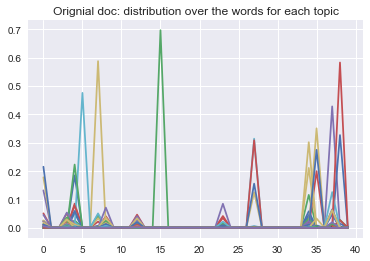

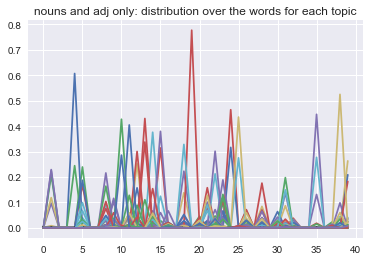

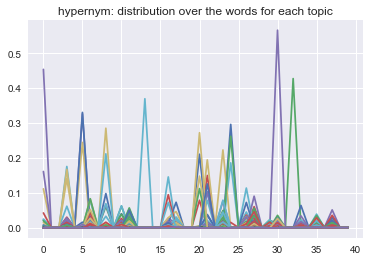

In [236]:
plt.title("Orignial doc: distribution over the words for each topic")
plt.plot(ori.components_ / ori.components_.sum(axis=1)[:, np.newaxis])
plt.show()
plt.title("nouns and adj only: distribution over the words for each topic")
plt.plot(speech.components_ / speech.components_.sum(axis=1)[:, np.newaxis])
plt.show()
plt.title("hypernym: distribution over the words for each topic")
plt.plot(hype.components_ / hype.components_.sum(axis=1)[:, np.newaxis])
plt.show()

## Perplexity comparison 
It seems there is a bug in Sklearn LDA when calculating perplexity. https://github.com/scikit-learn/scikit-learn/issues/6777 Perplexity not monotonically decreasing for batch Latent Dirichlet Allocation

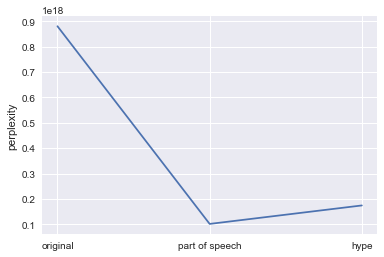

In [244]:
x = np.array([0,1,2])
my_xticks = ['original','part of speech', 'hype']
plt.xticks(x, my_xticks)
plt.plot(x, [ori.perplexity(original_doc_vec[0]),speech.perplexity(part_speech_vec[0]),hype.perplexity(hype_vec[0])])
plt.ylabel("perplexity")

In [201]:
from sklearn.decomposition import TruncatedSVD

sa = TruncatedSVD(n_components=10, n_iter=20).fit(part_speech_vec[0])

In [202]:
display_topics(sa, part_speech_vec[1], no_top_words)

Topic 0:
good food great steak french vegas service place time restaurant patio bellagio table nice dinner delicious bread view strip sauce
Topic 1:
steak frites sauce butter fries bread french soup medium filet onion wine cheese rare thin mignon order little warm tender
Topic 2:
good french breakfast soup eggs toast crepe cheese nice brunch onion hash benedict little fresh coffee salad salmon chicken cream
Topic 3:
vegas french restaurant patio time table breakfast bellagio las perfect dinner place delicious menu brunch strip toast paris eggs show
Topic 4:
french great soup onion toast cheese delicious bread place breakfast sauce salad fresh crepe blueberry cream lunch butter warm bistro
Topic 5:
food french service soup onion steak restaurant stars waiter quality bread fries ok excellent experience salty server bad bistro much
Topic 6:
place steak vegas breakfast french good strip las eggs toast paris frites brunch benedict coffee thin blueberry fries hotel prices
Topic 7:
bellagio v